In [9]:
import os
import pandas as pd

# Set the new file directory
os.chdir('Z:/Employee/A Bagwala/Gen AI and Python Stuff/Machine Learning/TiMER SeRies/')

# Read the CSV file
df = pd.read_csv("monthly-champagne-sales.csv")
df["Month"] = pd.to_datetime(df["Month"])

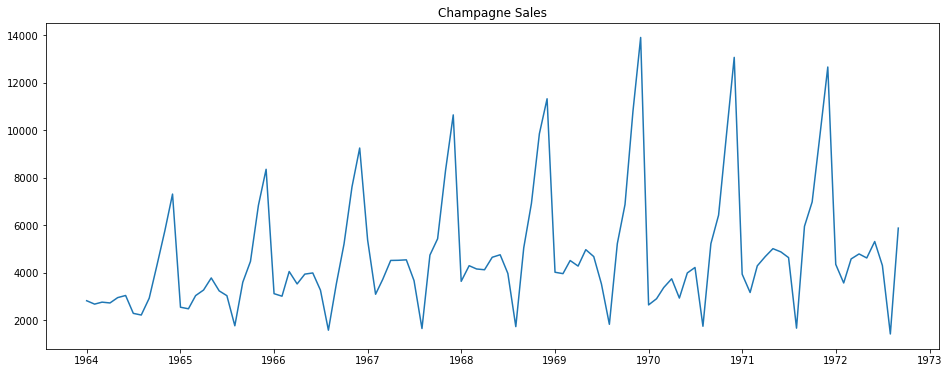

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the size of the plot
plt.figure(figsize=(16, 6))
plt.plot(df["Month"], df["Sales"])
plt.title("Champagne Sales")

# Show plot
plt.show()

### Insights:
- There seems to be no clear long term increasing or decreasing trend. Let's check Kendall's Tau test to check if there is trend.
- There is strong seasonality in the series.

In [15]:
from scipy.stats import kendalltau

# Perform Kendall's tau test
tau, p_value = kendalltau(df["Month"], df["Sales"])

print("Tau is",tau)
print("p-value is",p_value)

Tau is 0.2579227007920172
p-value is 9.673965284878172e-05


### Positive Tau indicates an increasing trend and p-value less than 0.05 indicates the trend is statistically signifcant.

In [8]:
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


### Let's divide Month into it's year and Month componenets.

In [11]:
df["year"] = df["Month"].dt.year
df["month"] = df["Month"].dt.strftime('%b')
df.head()

,Month,Sales,year,month
0,1964-01-01,2815,1964,Jan
1,1964-02-01,2672,1964,Feb
2,1964-03-01,2755,1964,Mar
3,1964-04-01,2721,1964,Apr
4,1964-05-01,2946,1964,May


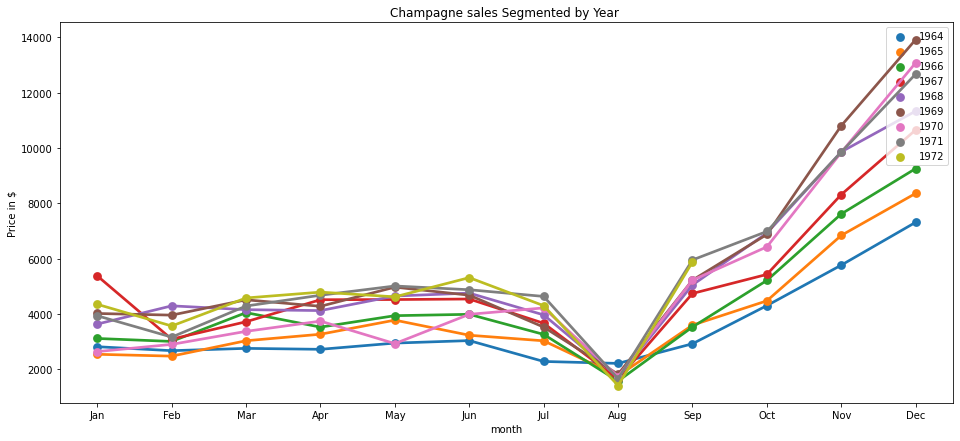

In [17]:
import seaborn as sns
#Setting the size of the plot
plt.figure(figsize=(16, 7))
sns.pointplot(x="month", y="Sales", hue="year", data=df, order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug',
       'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("month")
plt.ylabel("Price in $")
plt.title("Champagne sales Segmented by Year ")
plt.legend(loc='upper right')

### Insights:
- Every year there is a sharp drop in January and August.
- Post August drop, the sales keep on increasing rapidly till end of December every year.

### Let's plot Lag Plots to see if data is random or not.

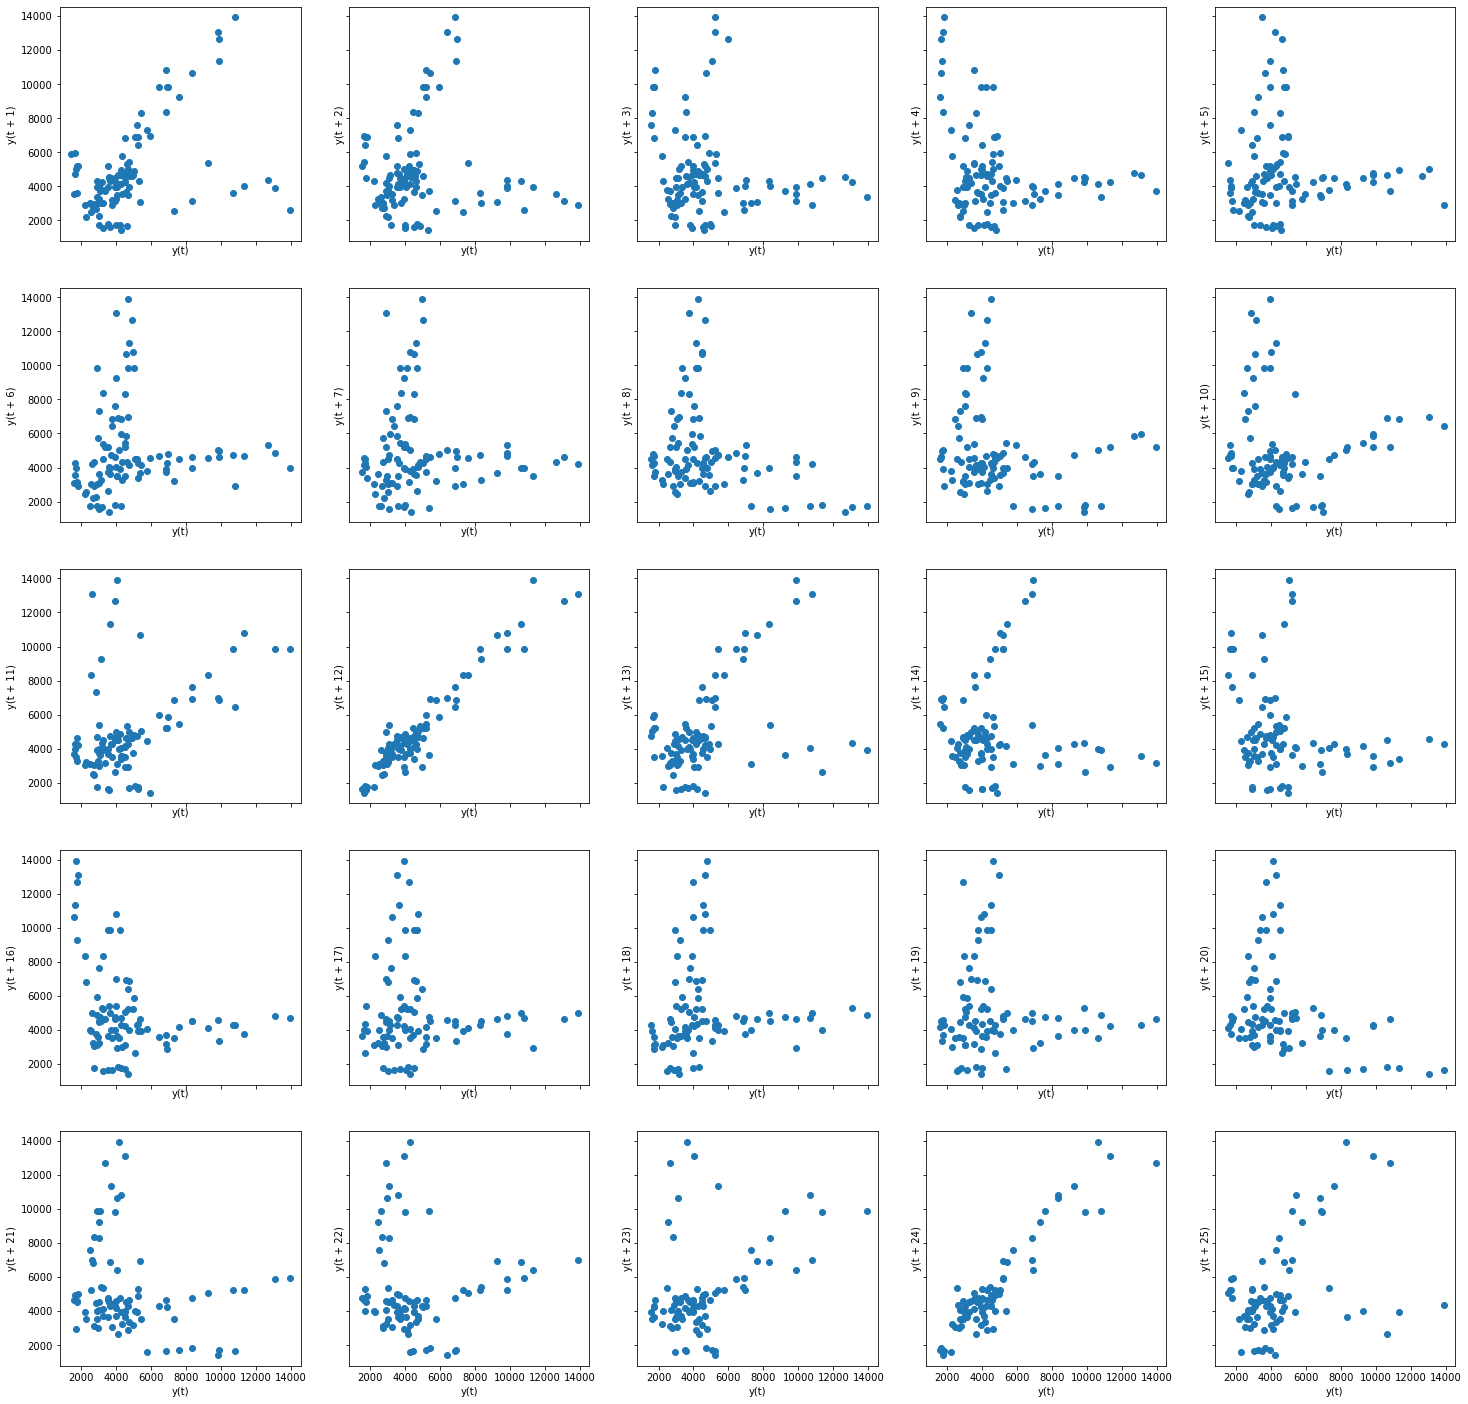

In [18]:
#Plotting 25 lag plots to determine randomness in data.
from pandas.plotting import lag_plot
plot_lags = 25
rows = int(plot_lags/5)
cols = int(plot_lags/5)
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(plot_lags)
fig.set_figheight(plot_lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df["Sales"], lag=count, ax=axes[i, j])
        count+=1

- Lag plots are not random indicating that there is some descernible pattern in the underlying data.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

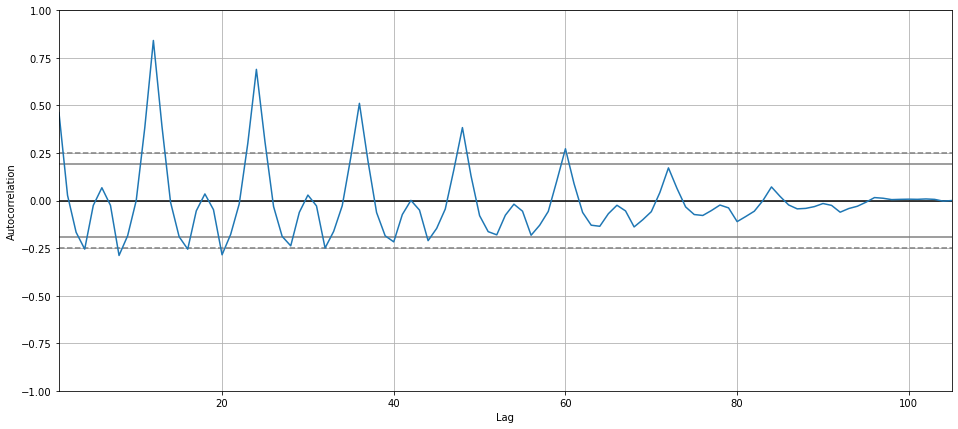

In [20]:
#Plotting graph to determine autocorrelation
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(16, 7))
autocorrelation_plot(df["Sales"])

- Strong positive autocorrelation exits at certain lag positions, and it dies down with increasing lags. Values beyond 0.25 sugests that autocorrelation is statistically significant and not due to random chance in the data.

In [21]:
#Decomposing to see the white noise.
decompose = df[["Month", "Sales"]]
decompose.index = df["Month"]
decompose = decompose[["Sales"]]
decompose.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


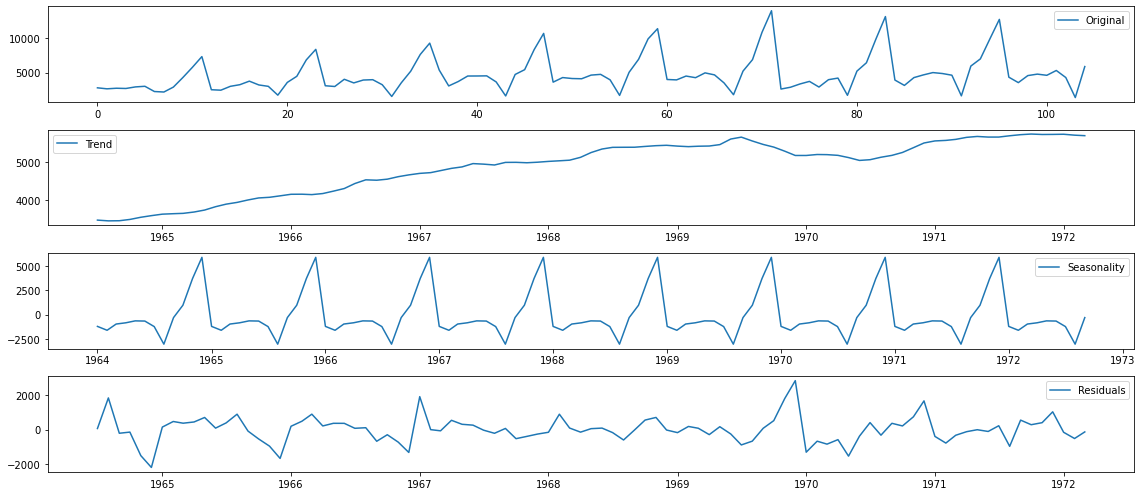

In [23]:
#Importing Decompose Model and plotting graph to see Trend, Seasonality, and Residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(decompose)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

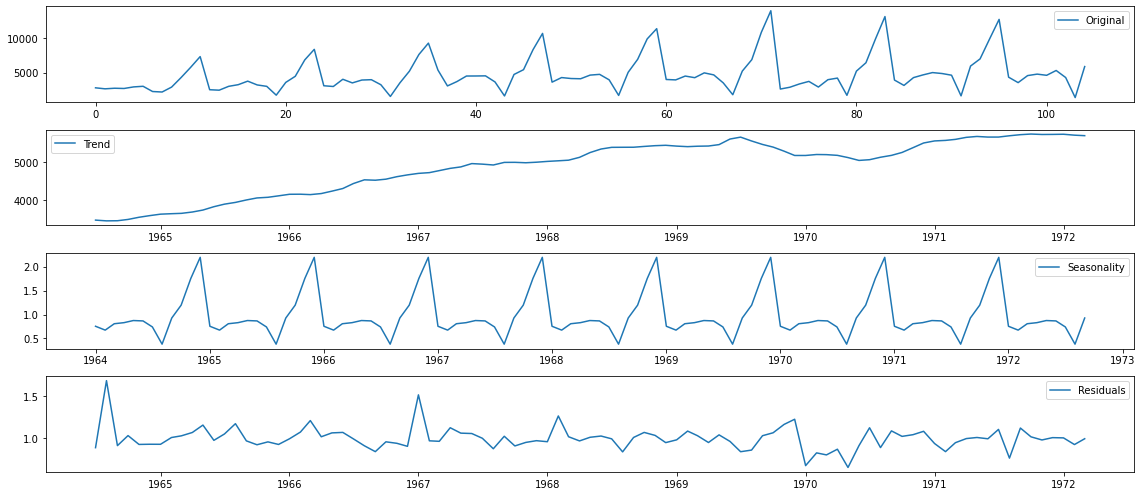

In [24]:
decomposition = seasonal_decompose(decompose, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df["Sales"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### Stationarity Check

In [26]:
import datetime
import math
from sklearn.metrics import mean_squared_error

In [27]:
df = pd.read_csv("monthly-champagne-sales.csv")
df["Month"] = pd.to_datetime(df["Month"])
df.index = df["Month"]
df = df[["Sales"]]
print(df.shape)
print(df.head())
x_train = df[df.index <datetime.datetime(1971, 1, 1, 0, 0, 0)]
x_test = df[df.index >=datetime.datetime(1971, 1, 1, 0, 0, 0)]
print(x_train.shape, x_test.shape)

(105, 1)
            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946
(84, 1) (21, 1)


Test Statistic                 -2.295554
p-value                         0.173406
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


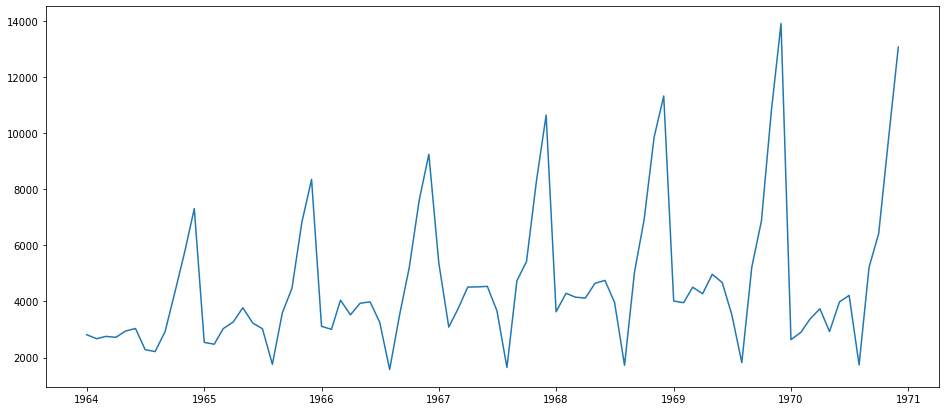

In [30]:
from statsmodels.tsa.stattools import adfuller

#Defining a custom function to perform Stationarity Test on the data
def stationarity_test(data):
    dftest = adfuller(data.Sales, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    plt.figure(figsize=(16, 7))
    plt.plot(data.index, data.Sales)
    plt.show()

stationarity_test(x_train)

### Insights from Stationary Check
- The data is nonstationary as p-value > 0.05.
- We need to apply log transformations to make variance constant.

Test Statistic                 -2.318672
p-value                         0.166017
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


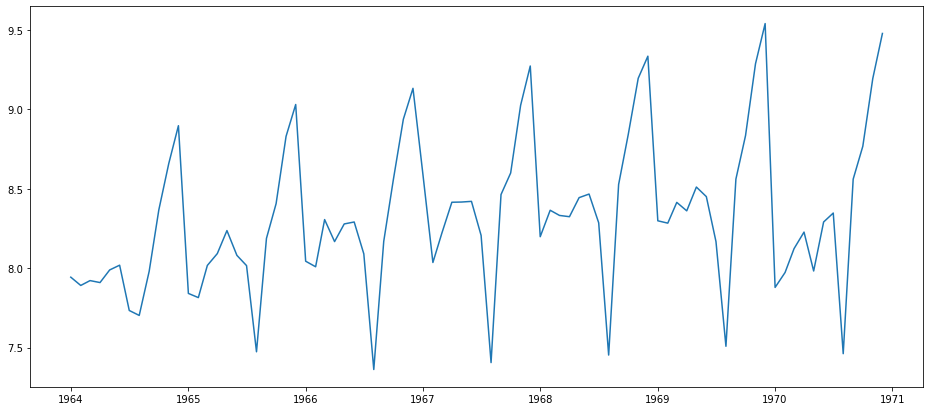

In [31]:
#Now take the log (To make variance constant) and check for stationary again
log_train = x_train
log_train = log_train["Sales"].apply(lambda x: math.log(x+1))
log_train = pd.DataFrame(log_train)
stationarity_test(log_train)

- Variance removed but time series is still non stationary.
- Now let's do first differencing. 

Test Statistic                -1.436191e+01
p-value                        9.816328e-27
#Lags Used                     1.000000e+01
Number of Observations Used    7.300000e+01
Critical Value (1%)           -3.523284e+00
Critical Value (5%)           -2.902031e+00
Critical Value (10%)          -2.588371e+00
dtype: float64


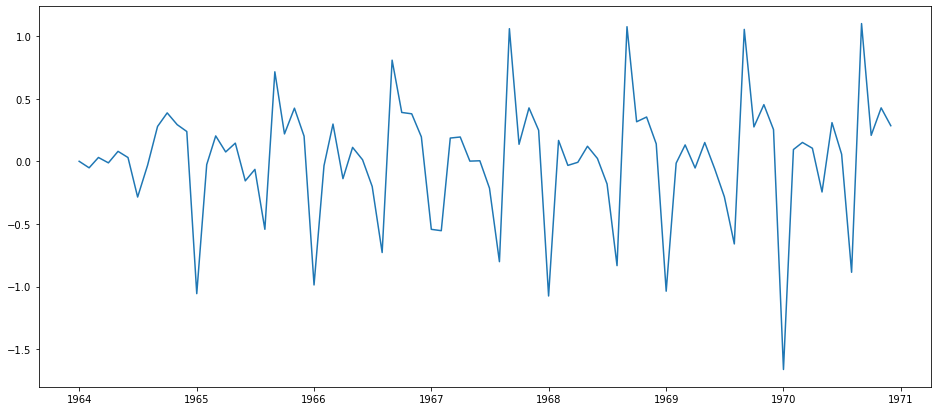

In [32]:
first_diff = log_train["Sales"] - log_train["Sales"].shift(1)
first_diff = first_diff.fillna(0)
first_diff = pd.DataFrame(first_diff)
stationarity_test(first_diff)

- p-value is now less than 0.05. Stationarity achieved.

Test Statistic                 -3.210025
p-value                         0.019412
#Lags Used                      2.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


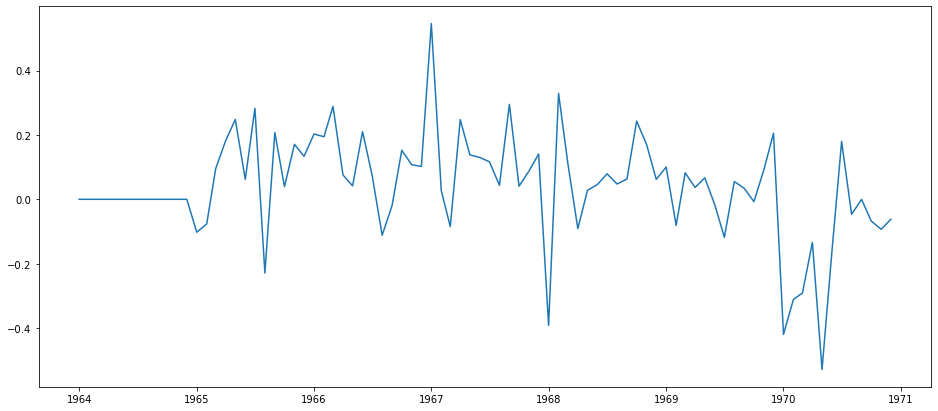

In [33]:
#Using Seasonal Differentiating for stationary check
seasonal_data_differenced = log_train["Sales"] - log_train["Sales"].shift(12)
seasonal_data_differenced = seasonal_data_differenced.fillna(0)
seasonal_data_differenced = pd.DataFrame(seasonal_data_differenced)
stationarity_test(seasonal_data_differenced)

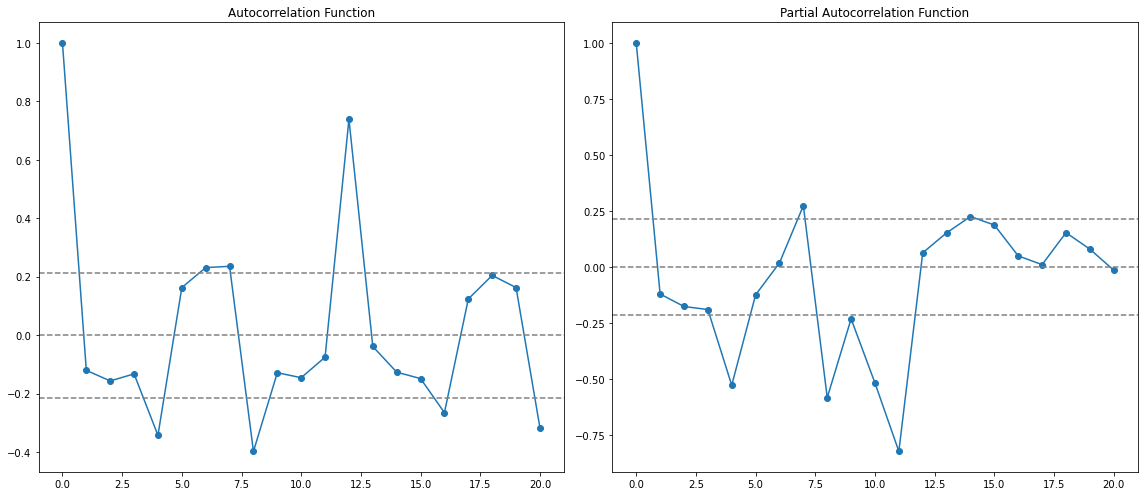

In [38]:
#Setting values for lag parameters for ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(first_diff, nlags=20)
lag_pacf = pacf(first_diff, nlags=20, method='ols')
plt.figure(figsize=(16, 7))

#Plotting ACF plot:
plt.subplot(121)
plt.plot(lag_acf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plotting PACF Plot:
plt.subplot(122)
plt.plot(lag_pacf, marker="o")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(first_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(first_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [39]:
#Plotting AR Model with p=1, d=1, q=0
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(log_train, order=(1, 1, 0), trend='t')
results_AR = model.fit()

C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


10953.216373428259


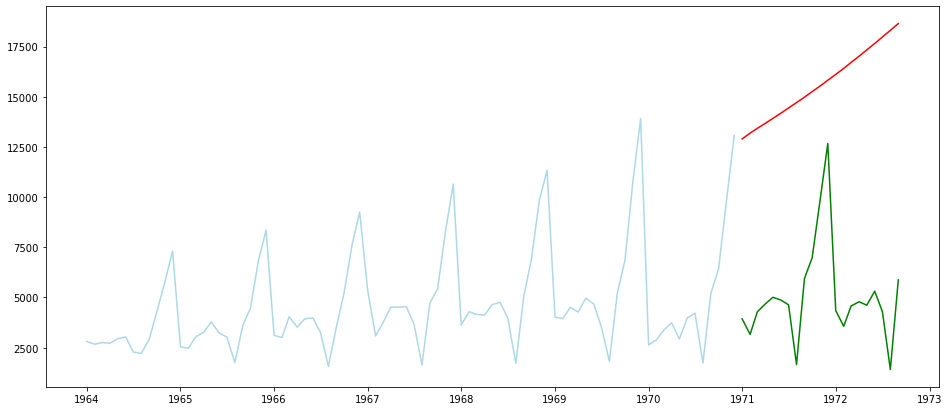

In [40]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")

#Code for checking Forecasting
pred = pd.DataFrame(results_AR.forecast(len(x_test)))
pred.columns = ["yhat"]
pred.index = x_test.index

#Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)

#Code for Measuring error.
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

- RMSE is too high. let's try only MA.

C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


9884.87658291582


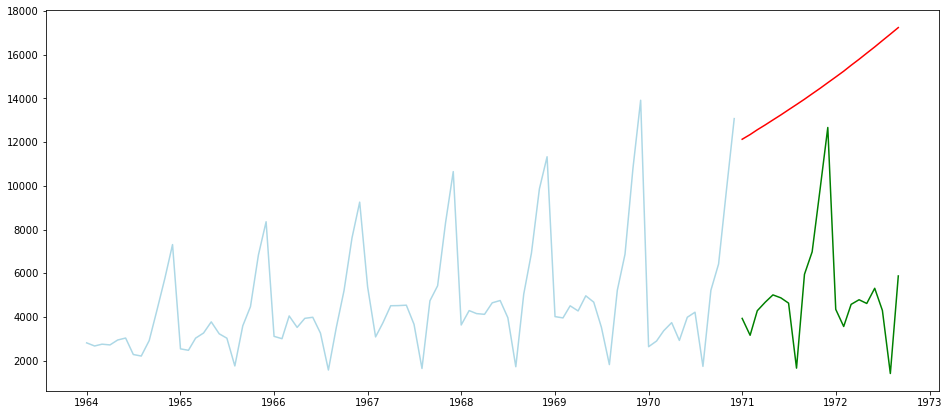

In [41]:
#Plotting MA Model with p=0, d=1, q=1

import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(log_train, order=(0, 1, 1), trend='t')
results_MA = model.fit()

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")


#Code for checking Forecasting
pred = pd.DataFrame(results_MA.forecast(len(x_test)))
pred.columns = ["yhat"]
pred.index = x_test.index


#Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)


#Code for Measuring error.
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

- RMSE has reduced but still too high.

C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asrar.bagwala\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserW

2813.617632722186


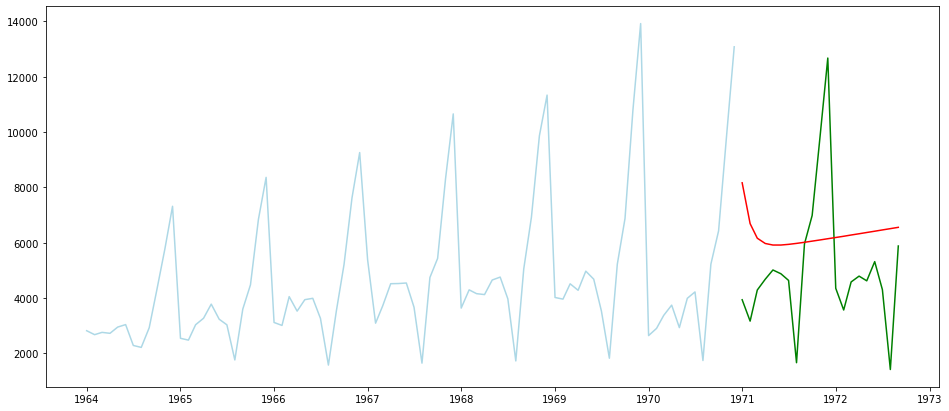

In [44]:
#Using both AR and MA with differencing and applying ARIMA Model with p=1, d=1, q=1
import statsmodels.api as sm
model = sm.tsa.arima.ARIMA(log_train, order=(1, 1, 1), trend='t')
results_ARIMA = model.fit()

plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")


#Code for checking Forecasting
pred = pd.DataFrame(results_ARIMA.forecast(len(x_test)))
pred.columns = ["yhat"]
pred.index = x_test.index


#Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)


#Code for Measuring error.
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

- RMSE further reduced. Let's try Auto ARIMA with auto selection of best values of p,d,q as well as P,D,Q(seasonal ARIMA)

In [35]:
!pip install pmdarima
import pmdarima as pm

In [36]:
auto_ARIMA_MODEL = pm.auto_arima(y = log_train, start_p=0, start_q=0, max_p=10, max_q=10, m=12, seasonal=True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=-15.840, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-9.498, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-32.828, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-47.856, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-46.209, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-46.575, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-46.205, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-48.412, Time=0.19 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-46.556, Time=0.39 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-17.731, Time=0.10 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-46.650, Time=0.25 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=-46.640, Time=0.33 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=-44.643, Time=0.53 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   :

1082.0873888931953


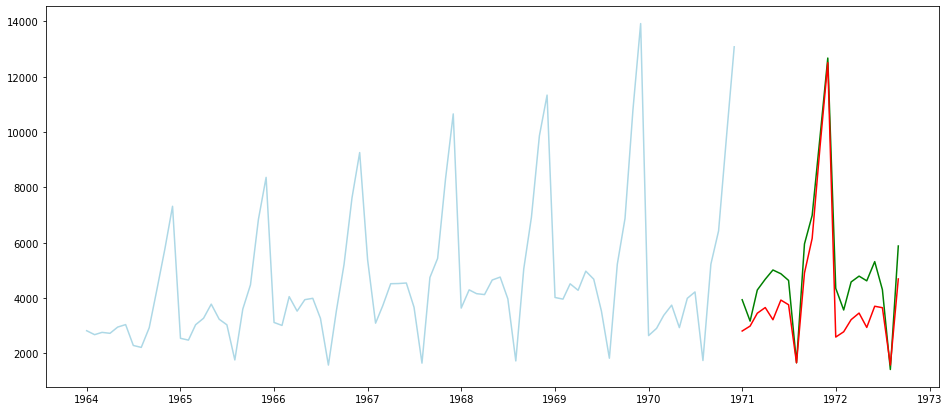

In [50]:
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")

pred = pd.DataFrame(auto_ARIMA_MODEL.predict(len(x_test)))
pred.columns = ["yhat"]
pred.index = x_test.index

#Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)

#Code for Measuring error.
measure = math.pow(mean_squared_error(x_test.values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

In [51]:
pred

,yhat
Month,
1971-01-01,2803.990217
1971-02-01,2982.933717
1971-03-01,3447.438493
1971-04-01,3652.215971
1971-05-01,3211.830715
1971-06-01,3922.356761
1971-07-01,3753.831370
1971-08-01,1654.010827
1971-09-01,4901.149658


In [57]:
x_test

,Sales
Month,
1971-01-01,3934
1971-02-01,3162
1971-03-01,4286
1971-04-01,4676
1971-05-01,5010
1971-06-01,4874
1971-07-01,4633
1971-08-01,1659
1971-09-01,5951


- Visualizing predictions for the next 12 months

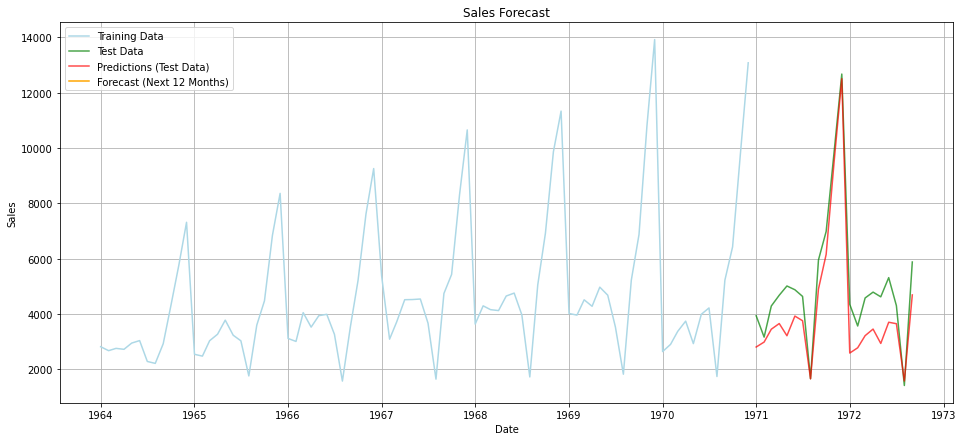

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming auto_ARIMA_MODEL is your fitted ARIMA model
# Forecasting for the next 12 months beyond the test data
forecast_steps = 12
forecast = auto_ARIMA_MODEL.predict(start=len(x_test), end=len(x_test) + forecast_steps - 1)

# Convert the forecasted values from log to the normal scale
forecast_values = np.exp(forecast) - 1

# Extend the existing test data index by 12 months for consistent plotting
extended_test_index = pd.date_range(start=x_test.index[0], periods=len(x_test) + forecast_steps, freq='M')

# Assign forecast values to the extended test data index for plotting consistency
forecast_df = pd.DataFrame({'Sales': forecast_values}, index=extended_test_index[len(x_test):])

# Plotting the original data, test data, and forecasted values with slight transparency
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue", label='Training Data')
plt.plot(x_test.index, x_test.values, color="green", alpha=0.7, label='Test Data')  # Added transparency
plt.plot(pred.index, pred.values, color="red", alpha=0.7, label='Predictions (Test Data)')  # Added transparency
plt.plot(forecast_df.index, forecast_df['Sales'], color="orange", label='Forecast (Next 12 Months)')  # New forecast with matching index
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.grid(True)
plt.show()


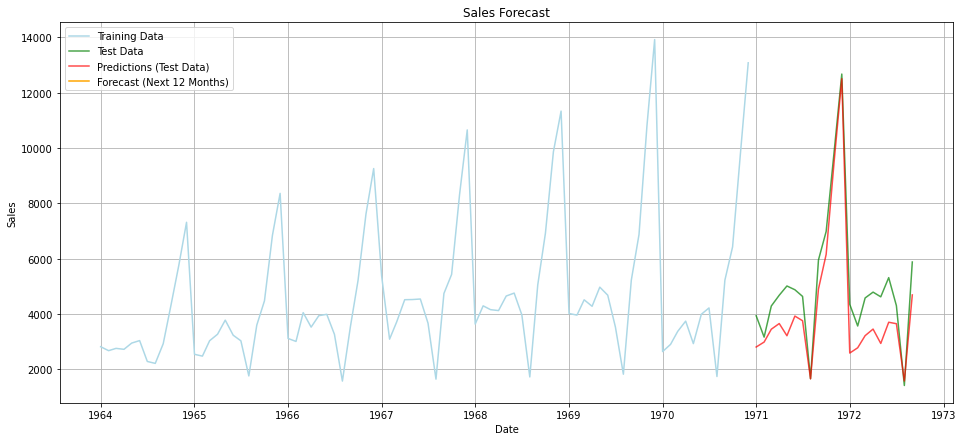

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming x_train and x_test are your training and testing data as pandas DataFrames with a 'Sales' column (replace with your actual data structure)

# Assuming auto_ARIMA_MODEL is your fitted ARIMA model

# Forecasting for the next 12 months beyond the test data
forecast_steps = 12
start_index = len(x_test)  # Start after the last test data point (October 1972)
forecast = auto_ARIMA_MODEL.predict(start=start_index, end=start_index + forecast_steps - 1)

# Convert the forecasted values from log to the normal scale (if applicable to your model)
forecast_values = np.exp(forecast) - 1  # Assuming log transformation, adjust if needed

# Create an index for the forecasted values (assuming the frequency is monthly)
forecast_index = pd.date_range(start=x_test.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Extend the existing test data index by 12 months for consistent plotting
extended_test_index = pd.date_range(start=x_test.index[0], periods=len(x_test) + forecast_steps, freq='M')

# Assign forecast values to the extended test data index for plotting consistency
forecast_df = pd.DataFrame({'Sales': forecast_values}, index=extended_test_index[len(x_test):])

# Plotting the original data, test data, and forecasted values with slight transparency
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue", label='Training Data')
plt.plot(x_test.index, x_test.values, color="green", alpha=0.7, label='Test Data')  # Added transparency
plt.plot(pred.index, pred.values, color="red", alpha=0.7, label='Predictions (Test Data)')  # Added transparency
plt.plot(forecast_df.index, forecast_df['Sales'], color="orange", label='Forecast (Next 12 Months)')  # New forecast with matching index
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.grid(True)
plt.show()
